In [1]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import brentq as root
from rhodium import *

In [2]:
# Construct the lake problem
def lake_problem(pollution_limit,
         b = 0.42,        # decay rate for P in lake (0.42 = irreversible)
         q = 2.0,         # recycling exponent
         mean = 0.02,     # mean of natural inflows
         stdev = 0.001,   # standard deviation of natural inflows
         alpha = 0.4,     # utility from pollution
         delta = 0.98,    # future utility discount rate
         nsamples = 100): # monte carlo sampling of natural inflows
    Pcrit = root(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    nvars = len(pollution_limit)
    X = np.zeros((nvars,))
    average_daily_P = np.zeros((nvars,))
    decisions = np.array(pollution_limit)
    reliability = 0.0

    for _ in range(nsamples):
        X[0] = 0.0

        natural_inflows = np.random.lognormal(
                math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
                math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
                size = nvars)

        for t in range(1,nvars):
            X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]
            average_daily_P[t] += X[t]/float(nsamples)

        reliability += np.sum(X < Pcrit)/float(nsamples*nvars)

    max_P = np.max(average_daily_P)
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(nvars)))
    inertia = np.sum(np.diff(decisions) > -0.02)/float(nvars-1)

    return (max_P, utility, inertia, reliability)

In [3]:
model = Model(lake_problem)

# Define all parameters to the model that we will be studying
model.parameters = [Parameter("pollution_limit"),
                    Parameter("b"),
                    Parameter("q"),
                    Parameter("mean"),
                    Parameter("stdev"),
                    Parameter("delta")]

# Define the model outputs
model.responses = [Response("max_P", Response.MINIMIZE),
                   Response("utility", Response.MAXIMIZE),
                   Response("inertia", Response.MAXIMIZE),
                   Response("reliability", Response.MAXIMIZE)]

# Define any constraints (can reference any parameter or response by name)
#model.constraints = [Constraint("reliability >= 0.95")]

# Some parameters are levers that we control via our policy
model.levers = [RealLever("pollution_limit", 0.0, 0.1, length=100)]

# Some parameters are exogeneous uncertainties, and we want to better
# understand how these uncertainties impact our model and decision making
# process
model.uncertainties = [UniformUncertainty("b", 0.1, 0.45),
                       UniformUncertainty("q", 2.0, 4.5),
                       UniformUncertainty("mean", 0.01, 0.05),
                       UniformUncertainty("stdev", 0.001, 0.005),
                       UniformUncertainty("delta", 0.93, 0.99)]

In [4]:
# Prepare the cache for storing intermediate results
setup_cache(file="example.cache")

# Optimize the model or get cached results if they exist.  Note that the
# call to optimize is wrapped in a lambda function to enable lazy evaluation.
output = cache("output", lambda: optimize(model, "NSGAII", 10000))

# save the Pareto approximate set as a .csv file
output.save('optimization_results.csv')

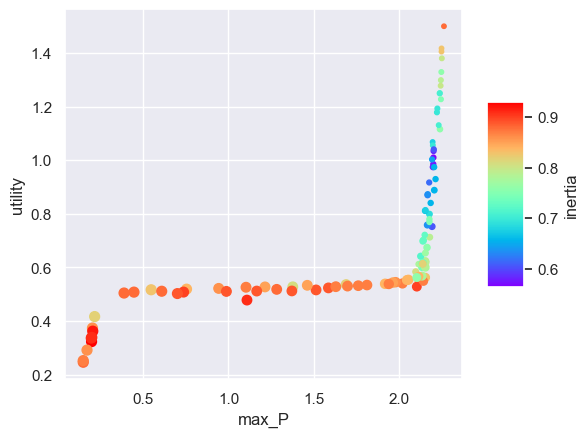

In [5]:
# Use Seaborn settings for pretty plots
sns.set()

# Plot the points in 2D space
scatter2d(model, output)
plt.show()

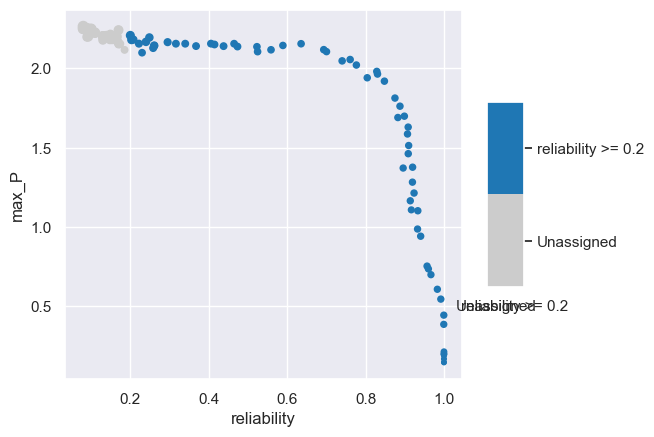

In [8]:
# Most of Rhodiums's plotting functions accept an optional expr argument for
# classifying or highlighting points meeting some condition
scatter2d(model, output, x="reliability", brush=Brush("reliability >= 0.2"))
plt.show()

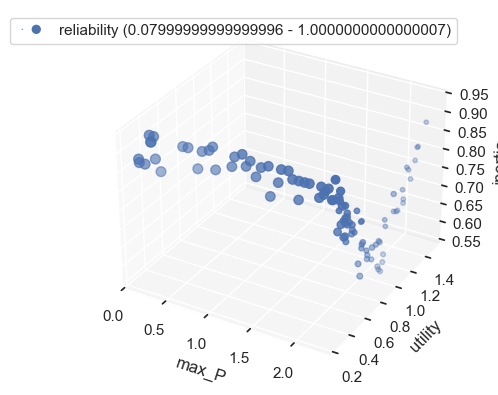

In [9]:
# Plot the points in 3D space
scatter3d(model, output, s="reliability", show_legend=True)
plt.show()

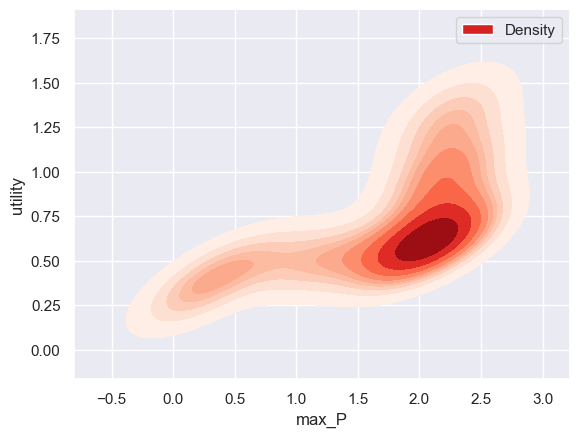

In [10]:
# Kernel density estimation plots show density contours for samples.  By
# default, it will show the density of all sampled points
kdeplot(model, output, x="max_P", y="utility")
plt.show()

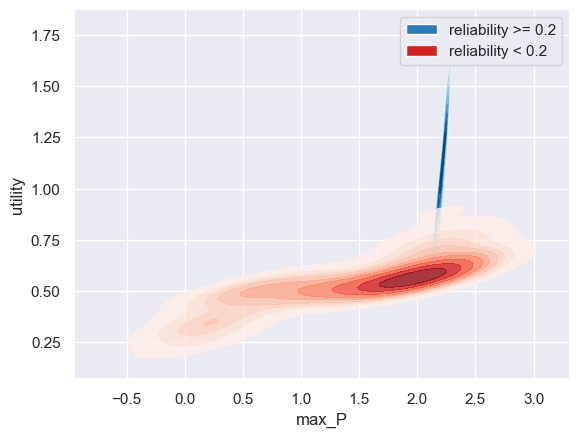

In [11]:
# Alternatively, we can show the density of all points meeting one or more
# conditions
kdeplot(model, output, x="max_P", y="utility",
        brush=["reliability >= 0.2", "reliability < 0.2"],
        alpha=0.8)
plt.show()

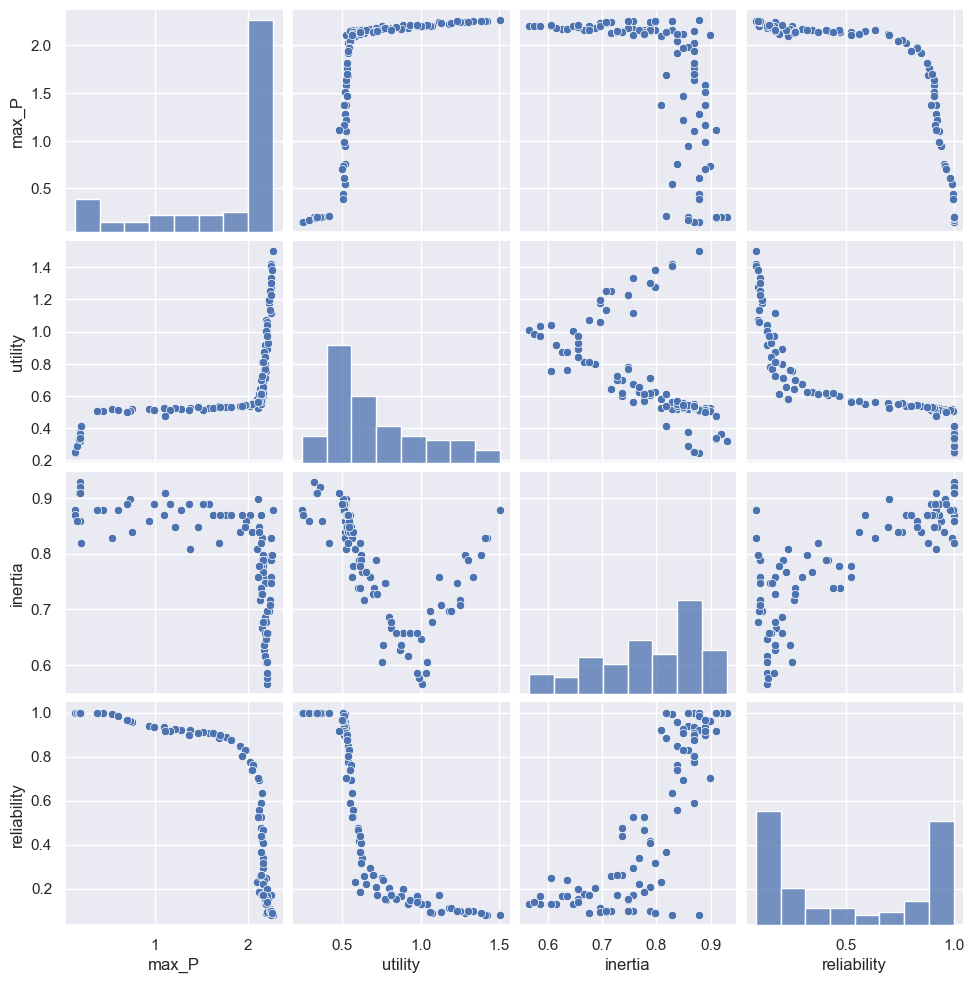

In [12]:
# Pairwise scatter plots shown 2D scatter plots for all outputs
pairs(model, output)
plt.show()

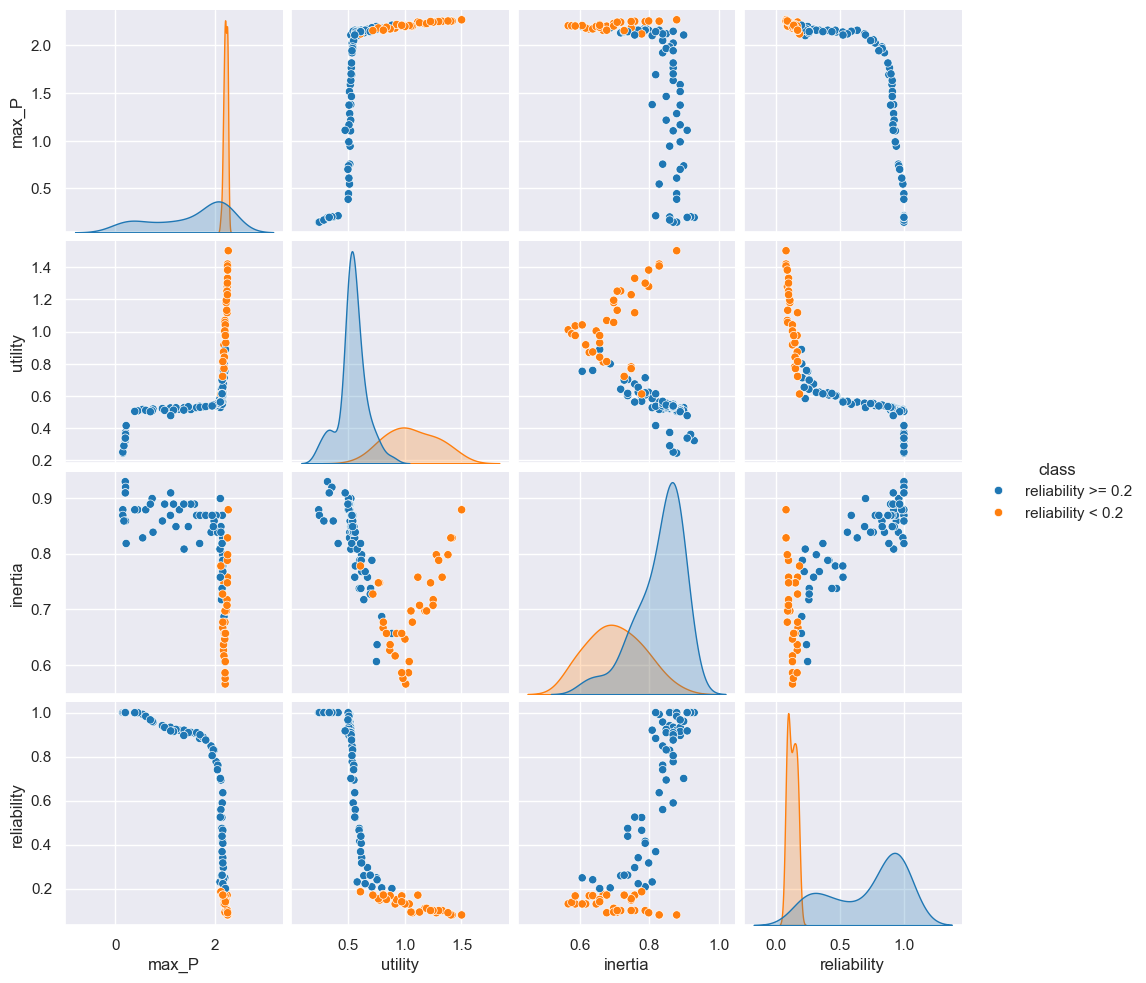

In [13]:
# We can also highlight points meeting one or more conditions
pairs(model, output,
      brush=["reliability >= 0.2", "reliability < 0.2"])
plt.show()


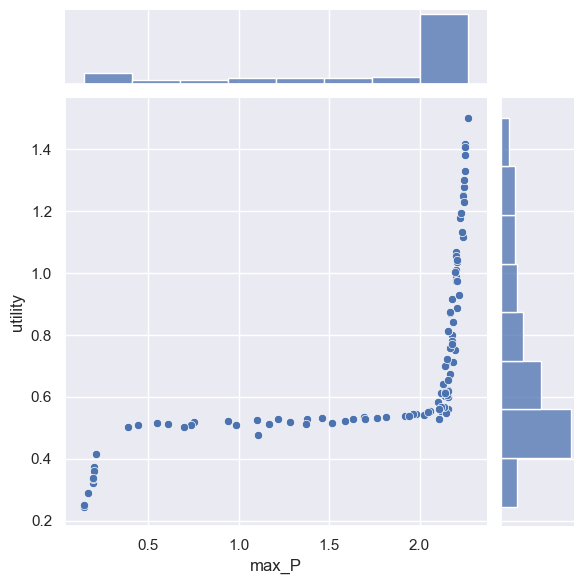

In [14]:
# Joint plots show a single pair of parameters in 2D, their distributions using
# histograms, and the Pearson correlation coefficient
joint(model, output, x="max_P", y="utility")
plt.show()

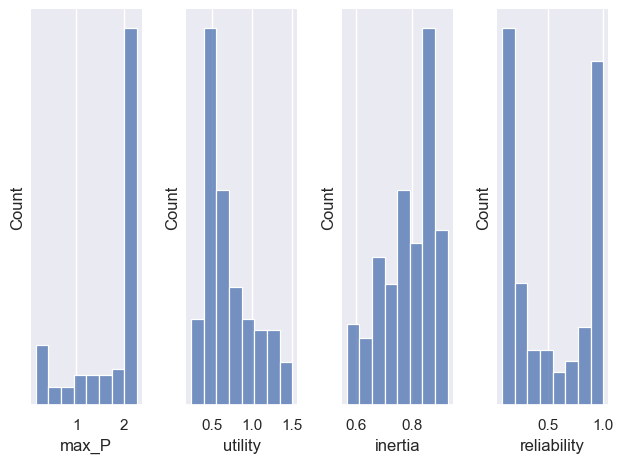

In [15]:
# A histogram of the distribution of points along each parameter
hist(model, output)
plt.show()

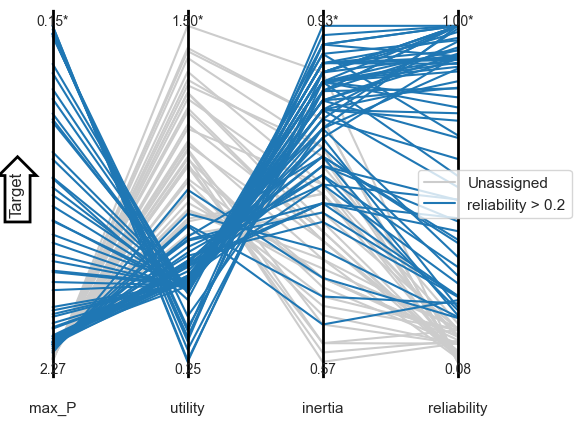

In [16]:
# A parallel coordinates plot to view interactions among responses
parallel_coordinates(model, output, colormap="rainbow", zorder="reliability", brush=Brush("reliability > 0.2"))     
plt.show()

In [19]:
# The remaining figures look better using Matplotlib's default settings
mpl.rcdefaults()

# We can manually construct policies for analysis.  A policy is simply a Python
# dict storing key-value pairs, one for each lever.
policy = {"pollution_limit" : [0.02]*100}

# Or select one of our optimization results
policy = output[3]

# Construct a specific policy and evaluate it against 1000 states-of-the-world
SOWs = sample_lhs(model, 100)
results = evaluate(model, update(SOWs, policy))


In [20]:
# save the results as a .csv file
results.save('reevaluation_results.csv')

In [21]:
# define performance criteria
metric = ["Reliable" if v["reliability"] > 0.9 else "Unreliable" for v in results]

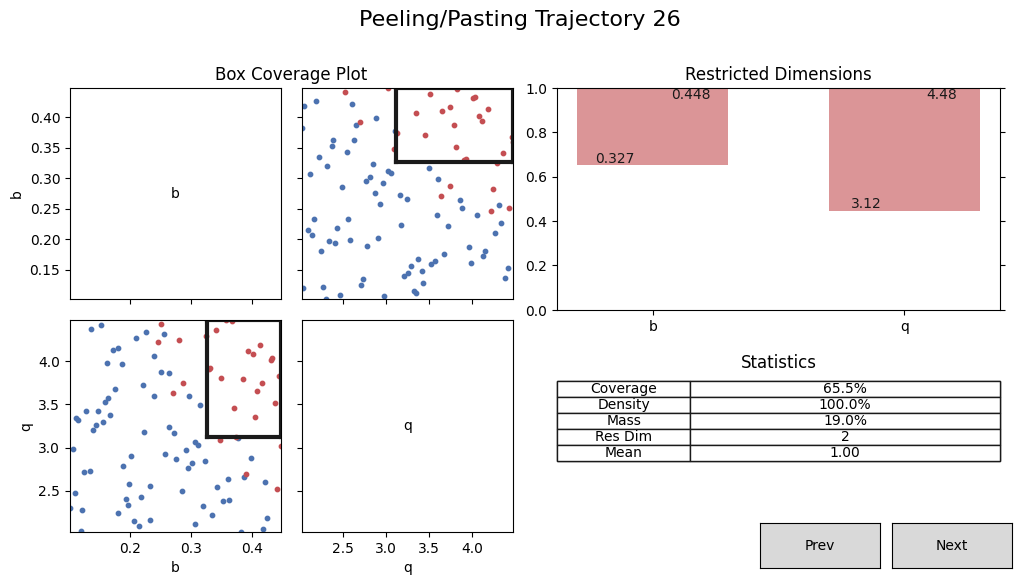

In [22]:
# Use PRIM to identify the key uncertainties if we require reliability > 0.9
p = Prim(results, metric, include=model.uncertainties.keys(), coi="Reliable")
box = p.find_box()
box.show_details()
plt.show()

In [24]:
# Sensitivity analysis using Morris method
print(sa(model, "reliability", policy=policy, method="morris", nsamples=1000, num_levels=4, grid_jump=2))

Morris Method's mu:
        b: +0.821837
        q: +0.599355
     mean: -0.123693
    stdev: -0.003619
    delta: +0.000380
Morris Method's mu* (confidence interval):
        b: +0.821837 (+0.091505)
        q: +0.599355 (+0.074237)
     mean: +0.123693 (+0.036175)
    stdev: +0.006175 (+0.004795)
    delta: +0.001127 (+0.000802)
Morris Method's sigma:
        b: +0.563105
        q: +0.556089
     mean: +0.243046
    stdev: +0.032693
    delta: +0.005206


In [27]:
# Sensitivity analysis using Sobol method
print(sa(model, "reliability", policy=policy, method="sobol", nsamples=10000, num_levels=4, grid_jump=2))

c:\Users\pkane\.conda\envs\rdm-sdm\lib\site-packages\SALib\sample\saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (834) is equal to `2^n`.
        
  warnings.warn(msg)


First order sensitivity indices (confidence interval):
        b: +0.520965 (+0.078809)
        q: +0.213000 (+0.059017)
     mean: +0.043843 (+0.028216)
    stdev: +0.001200 (+0.001250)
    delta: +0.000955 (+0.000694)
Total order sensitivity indices (confidence interval):
        b: +0.746200 (+0.076054)
        q: +0.454642 (+0.070687)
     mean: +0.125907 (+0.026356)
    stdev: +0.000149 (+0.000098)
    delta: +0.000053 (+0.000033)
Second order sensitivity indices (confidence interval):
            b - q: +0.133743 (+0.094311)
         b - mean: +0.002669 (+0.085622)
        b - stdev: -0.003011 (+0.079922)
        b - delta: -0.003122 (+0.079918)
         q - mean: +0.027565 (+0.070643)
        q - stdev: +0.033002 (+0.063864)
        q - delta: +0.033444 (+0.063661)
     mean - stdev: +0.017405 (+0.043998)
     mean - delta: +0.017102 (+0.043984)
    stdev - delta: -0.001805 (+0.001511)
